In [2]:
import numpy as np
import skimage as sk
from skimage import transform
from skimage.transform import pyramid_reduce
from skimage.transform import pyramid_expand
from skimage.draw import polygon
import os
import sys
root_folder = os.path.dirname(os.getcwd()) 
sys.path.insert(0,root_folder)
image_folder =  root_folder + "\\resources\\imgs\\faces\\"   
from PIL import Image
import imageio
import skimage
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull,Delaunay
from DIP_Library import featureDetectionDLIB, get_tf_model,warp_image
import cv2

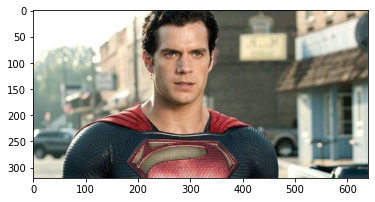

In [3]:
img_name = "superman.jpg"  
superman = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(superman) 
x,y,rgb = superman.shape

In [4]:
def plot_pyramid(pyramid):
    """
    Plots a pyramid array of images in one single plot

    Args:
        pyramid : Pyramid array to be plotted
    """
#     if(pyramid[0].shape[0] < pyramid[len(pyramid)-1].shape[0]):
#         pyramid = pyramid[::-1]
    rows, cols, dim = pyramid[0].shape
    composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)
    composite_image[:rows, :cols, :] = pyramid[0]

    i_row = 0
    for p in pyramid[1:]:
        n_rows, n_cols = p.shape[:2]
        composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
        i_row += n_rows

    fig, ax = plt.subplots()
#     if(pyramid[0].shape[0] < pyramid[len(pyramid)-1].shape[0]):
#         ax.imshow(composite_image[:,:,1],cmap='gray')
#     else:
    ax.imshow(composite_image)
    plt.show()

In [5]:
def get_gaussian_pyramid(img,downscale=2,**kwargs):
    """
    Makes the laplacian pyramid of an image

    Args:
        img : Image to make a laplacian pyramid off.
        Downscale (int, optional): Downscale value. Defaults to 2.

    Returns:
        G: Array of gaussian pyramid images
    """
    r = img.shape[0]
    c = img.shape[1]
    G = []
    var = img
    if isinstance(img[2][0][0], np.uint8):
        G.append(var/255)
    else:
        G.append(var)
    while r>8 and c>8:
        var = pyramid_reduce(var,downscale = downscale,multichannel=True)
        G.append(var)
        r = r/2
        c = c/2
    return G

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\2344588173.py:21: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  var = pyramid_reduce(var,downscale = downscale,multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


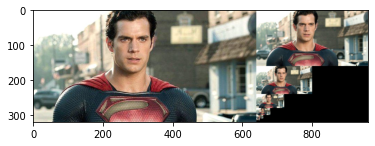

In [6]:
plot_pyramid(get_gaussian_pyramid(superman))

In [7]:
def get_laplacian_pyramid(img,upscale=2):
    """
    Makes the laplacian pyramid of an image

    Args:
        img : Image to make a laplacian pyramid off.
        upscale (int, optional): Upscale value for gaussian pyramid. Defaults to 2.

    Returns:
        L: Array of laplacian pyramid images
    """
    pyramid = get_gaussian_pyramid(img,upscale=upscale)
    L = []
    for i in range(len(pyramid)-1,-1,-1):
        if i == len(pyramid)-1:
            L.append(pyramid[i])
        else:
            prev = pyramid_expand(pyramid[i+1],upscale=upscale,multichannel=True)
            L.append(cv2.resize(pyramid[i],dsize=(prev.shape[1],prev.shape[0]),interpolation=cv2.INTER_CUBIC)-prev)
    L=L[::-1]
    return L

In [8]:
Lpyramid = get_laplacian_pyramid(superman)

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\2344588173.py:21: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  var = pyramid_reduce(var,downscale = downscale,multichannel=True)
C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3472033233.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(pyramid[i+1],upscale=upscale,multichannel=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


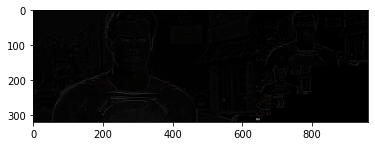

In [9]:
plot_pyramid(Lpyramid)

In [10]:
def reconstruct_image_from_laplacian(pyramid,upscale=2):
    """
    Reconstructs an image from the laplacian pyramid

    Args:
        pyramid : Laplacian pyramid to be reconstructed
        upscale (int, optional): Upscale value. Defaults to 2.

    Returns:
        R[len(R)-1]: The reconstructed image from the laplacian pyramid
        
    """
    R = []
    for i in range(len(pyramid)-1,-1,-1):
        if i == len(pyramid)-1:
            R.append(pyramid[len(pyramid)-1])
        else:
            prev = pyramid_expand(R[len(pyramid)-2-i],upscale=upscale,multichannel=True)
            R.append(cv2.resize(pyramid[i],dsize=(prev.shape[1],prev.shape[0]),interpolation=cv2.INTER_CUBIC)+prev)
    return R[len(R)-1]

7


C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3486014540.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(R[len(pyramid)-2-i],upscale=upscale,multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


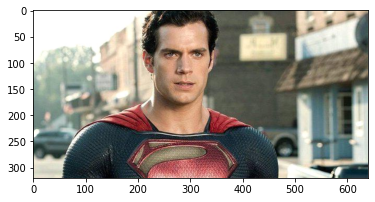

In [11]:
print(len(Lpyramid))
R = reconstruct_image_from_laplacian(Lpyramid)
plt.imshow(R)

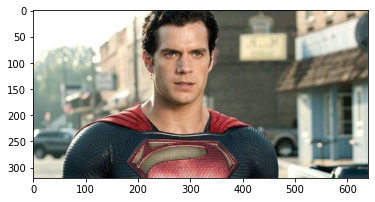

In [12]:
plt.imshow(superman)

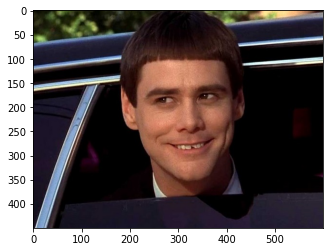

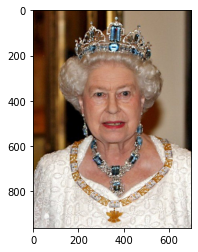

In [13]:
img_name = "carrey.jpg"
carrey = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(carrey)

img_name = "queen.jpg" 
queen = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(queen)
    

In [38]:
model = root_folder + "\\resources\\Models\\shape_predictor_68_face_landmarks.dat"
def convexHull(img,model,DEBUG=False,limited=None):
        """
        Calculates the convex hull of the face of an image

        Args:
                img : Image to fit convex hull to
                model : Model of the featurepoints of the face :  shape_predictor_68_face_landmarks.dat
                DEBUG: plot face with convex hull and triangles

        Returns:
                convex_h: Points that make up the convex hull
                traingles: The Delauney triangles from the convexhull points
        """
        pts = featureDetectionDLIB(img,model, True)                     # alle punten
        pts2 = featureDetectionDLIB(img,model, True)[0]                 # enkel feature punten
        convex = ConvexHull(pts2)                                       #convexHull van featurepunten van gezicht
        convex_h = np.zeros((0,2), tuple)
        if limited is None:
                for itr in convex.vertices:
                        convex_h = np.vstack((convex_h,pts2[itr]))
        if limited is not None:
                for itr in limited:
                        convex_h = np.vstack((convex_h,pts2[itr]))
        convex_b = np.vstack((convex_h, pts[1]))                        # convexHull samenplaatsen met cornerpunten om Ddelaunay triangles te kunnen maken     
        triangles = Delaunay(convex_b)
        if DEBUG:
            fig, (ax) = plt.subplots(nrows=1, ncols=1)
            ax.imshow(img)
            ax.triplot(convex_b[:,0], convex_b[:,1], triangles.simplices)
        return convex_h, triangles, convex_b, convex.vertices


In [15]:
model = root_folder + "\\resources\\Models\\shape_predictor_68_face_landmarks.dat"
pts1 = featureDetectionDLIB(carrey,model, True, True) 
pts2 = featureDetectionDLIB(queen,model, True, True)
triangles2 = Delaunay(pts2)

warped2 = warp_image(queen, pts2, triangles2,pts1, carrey.shape)

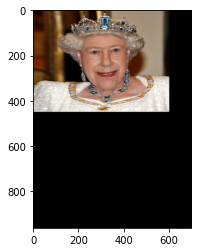

In [39]:
plt.imshow(warped2)

In [40]:
con1,tri1,conf,vert = convexHull(warped2,model=model)

pts: 2
pts2: 68


In [18]:
def makeConvexMask(shape,pts):
    """
    Make the mask of the convex hull of the warped image

    Args:
        shape : Shape of warped image
        pts : Points of the convex hull

    Returns:
        Mask: Return the mask for the face
    """
    mask = np.zeros((shape))
    r = pts[:,1]
    c = pts[:,0]
    rr, cc = polygon(r, c)
    mask[rr, cc] = 1
    mask[:,1]=1
    mask[:,shape[1]-1]=1
    mask[1,:]=1
    mask[shape[0]-1,:]=1
    return mask

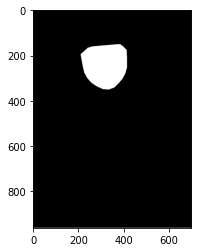

In [19]:
mask = makeConvexMask(warped2.shape,con1)
plt.figure()
plt.imshow(mask)

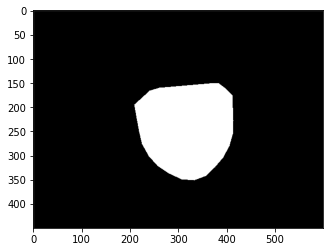

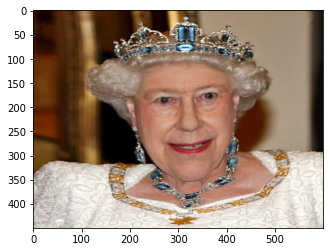

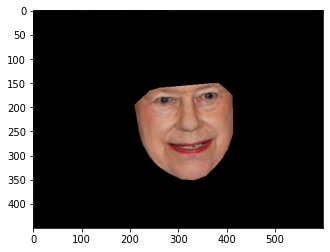

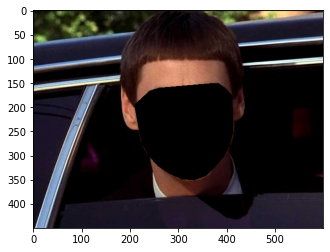

In [20]:
r,c,n = carrey.shape
mask2 = mask[:r,:c]
plt.figure()
plt.imshow(mask2)
nikki = warped2[:r,:c]
plt.figure()
plt.imshow(nikki)
face = nikki * mask2
plt.figure()
plt.imshow(face)
body = carrey/255 * (1-mask2)
plt.figure()
plt.imshow(body)

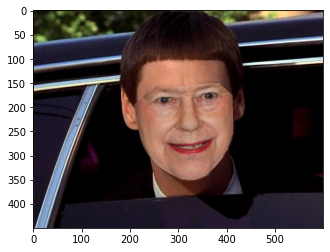

In [21]:
swap = body+face
plt.figure()
plt.imshow(swap)

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\2344588173.py:21: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  var = pyramid_reduce(var,downscale = downscale,multichannel=True)


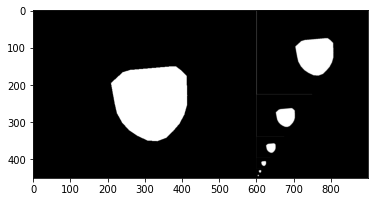

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3472033233.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(pyramid[i+1],upscale=upscale,multichannel=True)


15
16
16


In [22]:
gmask = get_gaussian_pyramid(mask2)
plot_pyramid(gmask)
Limg1 = get_laplacian_pyramid(carrey)
# plot_pyramid(Limg1)
Lnikki = get_laplacian_pyramid(nikki)
# plot_pyramid(Lnikki)
print(len(gmask[5]))
print(len(Limg1[5]))
print(len(Lnikki[5]))

In [23]:
def blend(gmask,limg1,limg2):
    """
    Blend 2 laplacian pyramid images using gmask (gaussian pyramid mask)
    Args:
        gmask Gaussian pyramid: Gaussian pyramid of mask
        limg1 Laplacian pyramid: laplacian pyramid of 1st image 
        limg2 Laplacian pyramid: laplacian pyramid of 2nd image

    Returns:
        image array: Blended image
    """
    b = []
    for i in range(0,len(gmask)):
        gmaskT = cv2.resize(gmask[i],dsize=(limg1[i].shape[1],limg1[i].shape[0]),interpolation=cv2.INTER_CUBIC)
        b.append(((1-gmaskT)*limg1[i])+(gmaskT*limg2[i]))
    
    return b

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3486014540.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(R[len(pyramid)-2-i],upscale=upscale,multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


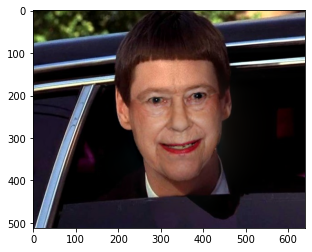

In [24]:
B = blend(gmask,Limg1,Lnikki)
RB = reconstruct_image_from_laplacian(B)
plt.imshow(RB)

In [25]:
def swap_faces(img1,img2=None,blendmode='pyramid',faceorder=(0,1),flip_faces=(True,True),detail='convexhull',plot_Delaunay_Keypoints='True'):
    """_summary_
    Swap face in image 1 with face in image 2 using the specified blendmode. If image 2 = None then image 1 should contain two faces and the faceorder arguments specifies the swapping order.

    Args:
        img1 (_type_): Image 1
        img2 (_type_, optional): Image 2. Defaults to None.
        blendmode (str, optional): Mode of blending of images can be alpha,pyramid or cv. Defaults to 'pyramid'.
        faceorder (tuple, optional): Order of faces swaped when image 1 has 2 faces. Defaults to (0,1).
        flip_faces (tuple, optional): Flips the orientation of the faces. Defaults to (True,True).
        detail (str, optional): Warp with convex hull or full feature warp. Defaults to 'convexhull'. Can also be full feature warp.
        plot_Delaunay_Keypoints (str, optional): If wanted the keypoints and Delauney triangles are plotted for the images. Defaults to 'True'.

    Returns:
        Faceswapped image: Return the image of the face of image 2 placed on the body of image 1 with the required blending technique in place
    """
    img_name = "frustrated.jpg" 
    fru = imageio.imread(image_folder+img_name)   
    if img2 is None:
        r,c,n = img1.shape
        if faceorder[0] == 0:
            img2 = img1[:,c//2:c]   
            img1b = img1[:,0:c//2]
        else:
            img2 = img1[:,0:c//2]
            img1b = img1[:,c//2:c]
        try:
            img1s = swap_faces(img1b,img2,blendmode=blendmode,plot_Delaunay_Keypoints=plot_Delaunay_Keypoints,detail=detail,flip_faces=(False,flip_faces[0]))
            plt.figure()
            plt.imshow(img1s)
            img2s = swap_faces(img2,img1b,blendmode=blendmode,plot_Delaunay_Keypoints=plot_Delaunay_Keypoints,detail=detail,flip_faces=(False,flip_faces[1]))
            plt.figure()
            plt.imshow(img2s)
            swapped = np.hstack([img1s,img2s])
            return swapped
        except:
            return fru
    else:
        if isinstance(img1[2][0][0], np.uint8):
            img1 = img1/255
        if isinstance(img2[2][0][0], np.uint8):
            img2 = img2/255

        if flip_faces[0] == True:
            img1 = np.fliplr(img1)
        if flip_faces[1] == True:
            img2 = np.fliplr(img2)
        model = root_folder + "\\resources\\Models\\shape_predictor_68_face_landmarks.dat"
        
        if detail == 'convexhull':
            con1,tri1,conf1,vert1 = convexHull(img1,model=model,DEBUG=plot_Delaunay_Keypoints)
            con2,tri2,conf2,vert2 = convexHull(img2,model=model,DEBUG=plot_Delaunay_Keypoints)
            # print(len(con1))
            # print(len(con2))
            div = len(con1)-len(con2)
            print("div: "+str(div))
            if div > 0:
                con1,tri1,conf1,vert1 = convexHull(img1,model=model,limited=vert2,DEBUG=plot_Delaunay_Keypoints)
            elif div < 0:
                con2,tri2,conf2,vert2 = convexHull(img2,model=model,limited=vert1,DEBUG=plot_Delaunay_Keypoints)
            # print(len(tri1.simplices))
            # print(len(tri2.simplices))
            try:
                warped2 = warp_image(img2, conf2, tri2,conf1, img1.shape)
            except:
                print('Image does not have enough recognisable faces')
                return 
            if plot_Delaunay_Keypoints == True:
                plt.figure()
                plt.title("warped2")
                plt.imshow(warped2)
        else:
            pts1 = featureDetectionDLIB(img1,model, True, True) 
            pts2 = featureDetectionDLIB(img2,model, True, True)
            # print(len(pts1))
            triangles2 = Delaunay(pts2)
            # print(len(triangles2.simplices))
            try:
                warped2 = warp_image(img2, pts2, triangles2,pts1, img1.shape)
            except:
                print('Image does not have enough recognisable faces')
                return 
        con1,tri1,conf1,vert = convexHull(warped2,model=model,DEBUG=plot_Delaunay_Keypoints)
            
        mask = makeConvexMask(warped2.shape,con1)
        r,c,n = img1.shape
        mask2 = mask[:r,:c]         
        warp = warped2[:r,:c]
        if blendmode == 'pyramid':
            gmask = get_gaussian_pyramid(mask2)
            Limg1 = get_laplacian_pyramid(img1)
            Lwarp = get_laplacian_pyramid(warp)
            B = blend(gmask,Limg1,Lwarp)
            swap_pyramid = reconstruct_image_from_laplacian(B)  
            return swap_pyramid
        elif blendmode == 'alpha':
            face = warp * mask2
            body = img1 * (1-mask2)
            swap_alpha = body+face
            return swap_alpha 
        elif blendmode == 'cv':
            # print(type(img1[0][0][0]))
            img1c = np.uint8(img1*255)
            img2c = np.uint8(warp*255)
            mask3 = np.uint8(mask2*255)
            center = (c//2,r//2)
            swap_cv2 = cv2.seamlessClone(img2c,img1c,mask3,center, cv2.NORMAL_CLONE)
            return swap_cv2
        else:
            print('error wrong blendmode try: pyramid,alpha or cv')
            return fru
    

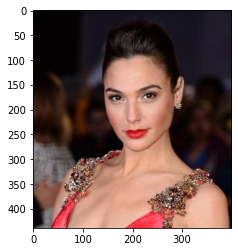

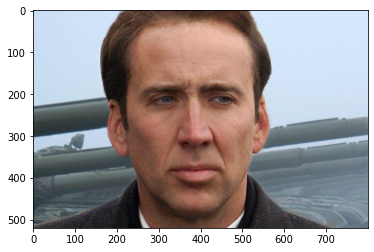

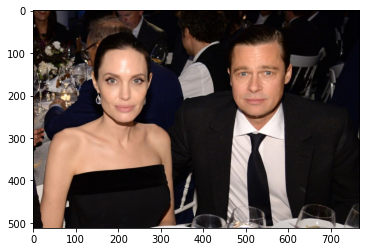

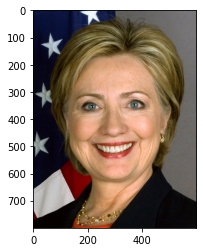

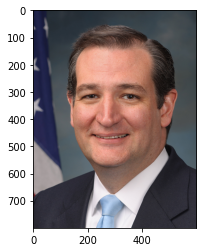

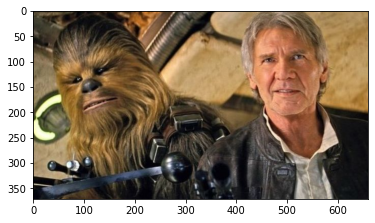

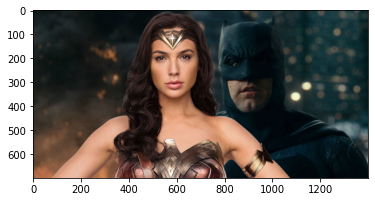

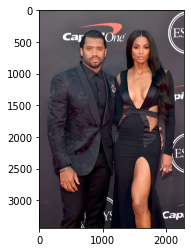

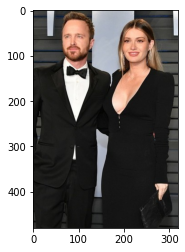

In [26]:
img_name = "gal_gadot.jpg" 
galgadot = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(galgadot)    
img_name = "nicolas_cage.jpg" 
nickcage = imageio.imread(image_folder+img_name)       
plt.figure()
plt.imshow(nickcage)
img_name = "brangelina.jpg" 
brangelina = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(brangelina)
img_name = "hillary_clinton.jpg" 
clinton = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(clinton)
img_name = "ted_cruz.jpg" 
cruz = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(cruz)
img_name = "han_solo.jpg" 
solo = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(solo)
img_name = "wonderwoman1.jpg" 
ww1 = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(ww1)
img_name = "idk2.jpg" 
onbekend = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(onbekend)
img_name = "aaron_paul.jpg" 
aaron_paul = imageio.imread(image_folder+img_name)            
plt.figure()
plt.imshow(aaron_paul)


pts[array([[143, 178],
       [145, 194],
       [149, 210],
       [154, 227],
       [161, 242],
       [171, 255],
       [182, 268],
       [195, 280],
       [210, 283],
       [226, 279],
       [243, 267],
       [259, 253],
       [272, 237],
       [280, 219],
       [283, 199],
       [283, 179],
       [282, 159],
       [144, 163],
       [151, 157],
       [162, 159],
       [172, 162],
       [182, 166],
       [208, 164],
       [220, 157],
       [232, 152],
       [246, 150],
       [258, 153],
       [197, 178],
       [198, 192],
       [198, 205],
       [199, 218],
       [191, 224],
       [196, 226],
       [201, 228],
       [207, 225],
       [212, 223],
       [158, 178],
       [165, 173],
       [174, 174],
       [182, 180],
       [173, 182],
       [165, 182],
       [220, 178],
       [226, 171],
       [235, 170],
       [244, 173],
       [237, 178],
       [228, 179],
       [182, 245],
       [190, 242],
       [197, 240],
       [203, 242],
       [

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\2344588173.py:21: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  var = pyramid_reduce(var,downscale = downscale,multichannel=True)
C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3472033233.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(pyramid[i+1],upscale=upscale,multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


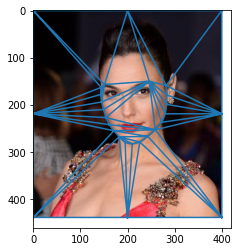

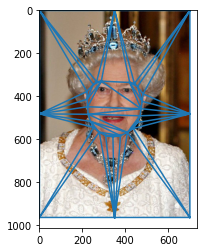

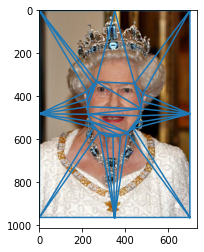

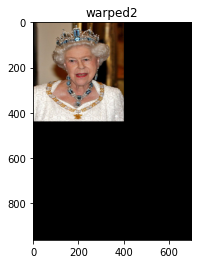

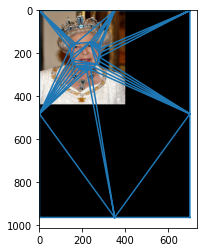

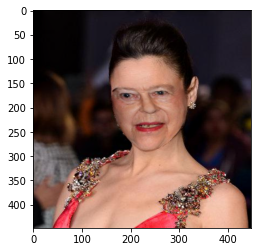

In [27]:
swapped = swap_faces(galgadot,queen,blendmode='pyramid',plot_Delaunay_Keypoints=True,detail='convexhull',flip_faces=(False,True))
plt.figure()
plt.imshow(swapped)

pts[array([[228,  84],
       [229,  99],
       [230, 114],
       [233, 129],
       [237, 143],
       [246, 156],
       [258, 166],
       [272, 175],
       [288, 178],
       [302, 176],
       [313, 167],
       [323, 156],
       [330, 143],
       [333, 129],
       [335, 114],
       [337,  99],
       [338,  85],
       [241,  78],
       [250,  73],
       [261,  73],
       [272,  75],
       [283,  78],
       [297,  77],
       [307,  74],
       [316,  72],
       [326,  73],
       [332,  79],
       [290,  85],
       [291,  94],
       [291, 103],
       [292, 113],
       [280, 120],
       [286, 121],
       [291, 123],
       [296, 121],
       [301, 120],
       [254,  86],
       [261,  82],
       [268,  82],
       [274,  87],
       [267,  89],
       [260,  89],
       [303,  86],
       [309,  82],
       [316,  82],
       [321,  86],
       [317,  89],
       [310,  88],
       [271, 140],
       [278, 137],
       [286, 135],
       [291, 137],
       [

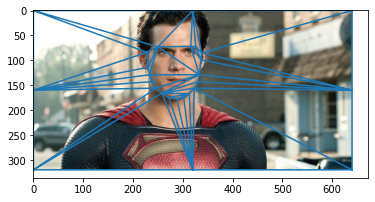

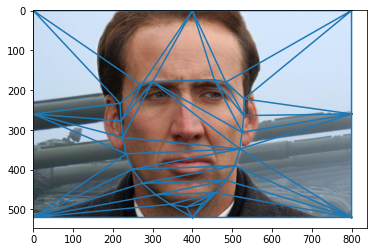

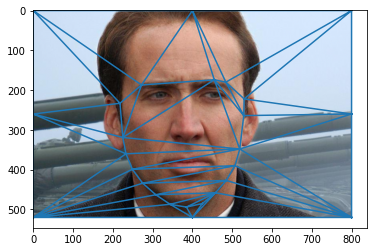

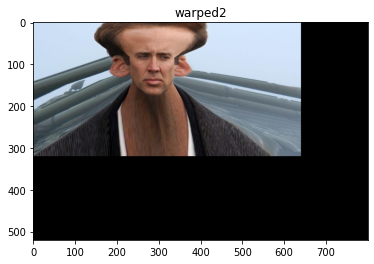

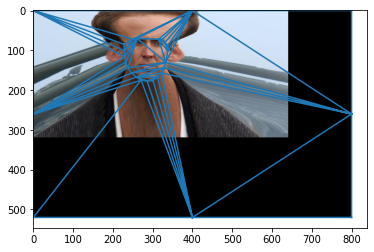

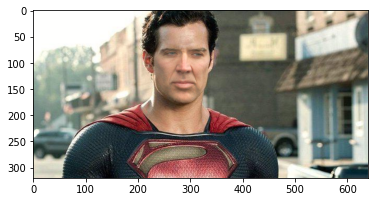

In [28]:
swapped = swap_faces(superman,nickcage,blendmode='cv',plot_Delaunay_Keypoints=True,detail='convexhull',flip_faces=(False,False))
plt.figure()
plt.imshow(swapped)

pts[array([[151, 157],
       [153, 176],
       [155, 194],
       [157, 212],
       [162, 228],
       [172, 242],
       [184, 254],
       [198, 262],
       [214, 264],
       [228, 262],
       [240, 253],
       [251, 242],
       [259, 229],
       [264, 214],
       [267, 199],
       [270, 182],
       [272, 165],
       [163, 153],
       [172, 149],
       [183, 149],
       [194, 151],
       [204, 155],
       [231, 155],
       [240, 151],
       [251, 150],
       [260, 151],
       [267, 157],
       [217, 168],
       [217, 180],
       [217, 192],
       [217, 203],
       [205, 208],
       [211, 210],
       [216, 213],
       [222, 211],
       [227, 208],
       [175, 166],
       [182, 163],
       [191, 164],
       [199, 170],
       [190, 171],
       [181, 170],
       [232, 170],
       [239, 164],
       [248, 164],
       [255, 168],
       [248, 172],
       [240, 172],
       [192, 226],
       [200, 223],
       [209, 222],
       [215, 224],
       [

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\2344588173.py:21: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  var = pyramid_reduce(var,downscale = downscale,multichannel=True)
C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3472033233.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(pyramid[i+1],upscale=upscale,multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pts[array([[ 79, 151],
       [ 81, 169],
       [ 83, 186],
       [ 86, 202],
       [ 91, 216],
       [ 99, 229],
       [110, 239],
       [123, 247],
       [139, 249],
       [156, 247],
       [171, 239],
       [185, 228],
       [196, 215],
       [202, 200],
       [204, 183],
       [207, 165],
       [210, 147],
       [ 87, 142],
       [ 94, 135],
       [104, 132],
       [115, 132],
       [125, 136],
       [147, 134],
       [159, 130],
       [171, 128],
       [183, 131],
       [193, 138],
       [136, 149],
       [135, 161],
       [135, 173],
       [134, 185],
       [125, 191],
       [130, 193],
       [135, 195],
       [141, 193],
       [147, 191],
       [100, 152],
       [106, 146],
       [115, 146],
       [122, 153],
       [114, 155],
       [106, 155],
       [156, 151],
       [162, 144],
       [171, 144],
       [179, 149],
       [172, 152],
       [164, 153],
       [115, 211],
       [123, 209],
       [130, 208],
       [136, 209],
       [

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\2344588173.py:21: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  var = pyramid_reduce(var,downscale = downscale,multichannel=True)
C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3472033233.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(pyramid[i+1],upscale=upscale,multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


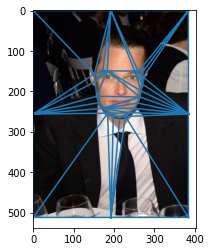

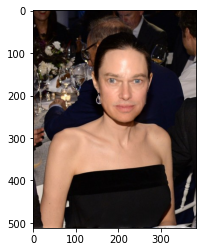

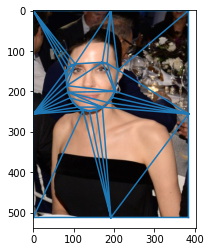

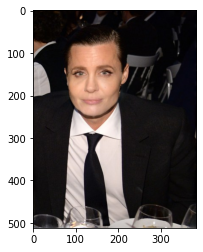

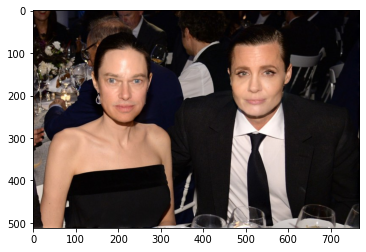

In [29]:
swapped = swap_faces(brangelina,blendmode='pyramid',plot_Delaunay_Keypoints=True,detail='all')
plt.figure()
plt.imshow(swapped)


pts[array([[431, 108],
       [435, 125],
       [439, 142],
       [444, 158],
       [450, 172],
       [460, 185],
       [472, 194],
       [485, 202],
       [502, 204],
       [520, 202],
       [536, 195],
       [549, 184],
       [559, 169],
       [564, 152],
       [567, 134],
       [569, 115],
       [570,  96],
       [441,  95],
       [447,  87],
       [457,  84],
       [468,  83],
       [479,  84],
       [502,  83],
       [514,  78],
       [527,  76],
       [540,  77],
       [549,  85],
       [491,  95],
       [492, 106],
       [492, 117],
       [492, 129],
       [481, 136],
       [488, 138],
       [495, 139],
       [503, 136],
       [511, 135],
       [455, 101],
       [461,  96],
       [468,  94],
       [475, 100],
       [468, 101],
       [461, 102],
       [513,  97],
       [519,  90],
       [527,  89],
       [534,  94],
       [528,  96],
       [520,  97],
       [474, 160],
       [482, 156],
       [490, 154],
       [497, 155],
       [

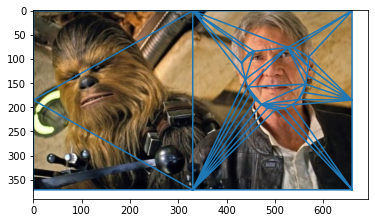

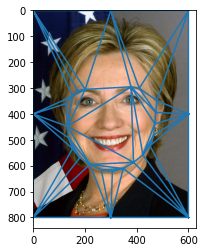

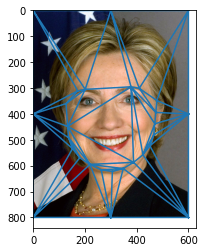

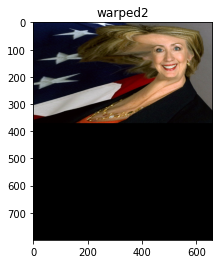

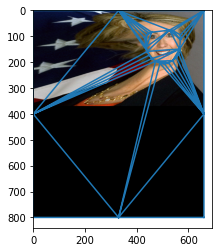

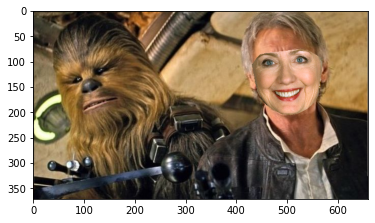

In [30]:
swapped = swap_faces(solo,clinton,blendmode='alpha',plot_Delaunay_Keypoints=True,detail='convexhull',flip_faces=(False,False))
plt.figure()
plt.imshow(swapped)

pts[array([[150, 329],
       [148, 366],
       [150, 404],
       [153, 442],
       [162, 479],
       [180, 512],
       [207, 540],
       [238, 564],
       [277, 572],
       [321, 567],
       [365, 548],
       [405, 525],
       [436, 495],
       [453, 458],
       [460, 416],
       [465, 374],
       [467, 331],
       [159, 293],
       [174, 276],
       [197, 269],
       [222, 271],
       [247, 280],
       [302, 279],
       [333, 269],
       [365, 269],
       [396, 280],
       [420, 297],
       [273, 313],
       [272, 344],
       [270, 375],
       [268, 406],
       [241, 419],
       [254, 426],
       [270, 432],
       [288, 425],
       [306, 419],
       [189, 320],
       [202, 310],
       [221, 310],
       [239, 321],
       [220, 324],
       [202, 325],
       [324, 322],
       [342, 310],
       [362, 311],
       [381, 322],
       [362, 327],
       [342, 326],
       [211, 458],
       [232, 455],
       [254, 454],
       [273, 459],
       [

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\2344588173.py:21: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  var = pyramid_reduce(var,downscale = downscale,multichannel=True)
C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3472033233.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(pyramid[i+1],upscale=upscale,multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


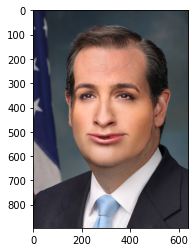

In [31]:
swapped = swap_faces(cruz,ww1,blendmode='pyramid',plot_Delaunay_Keypoints=False,detail='all',flip_faces=(False,False))
plt.figure()
plt.imshow(swapped)

pts[array([[ 690,  626],
       [ 691,  674],
       [ 696,  722],
       [ 705,  770],
       [ 724,  813],
       [ 754,  847],
       [ 793,  876],
       [ 836,  899],
       [ 882,  906],
       [ 926,  897],
       [ 962,  869],
       [ 994,  837],
       [1018,  800],
       [1032,  756],
       [1036,  710],
       [1039,  665],
       [1038,  620],
       [ 730,  591],
       [ 755,  571],
       [ 789,  564],
       [ 825,  568],
       [ 860,  581],
       [ 902,  584],
       [ 932,  572],
       [ 963,  569],
       [ 991,  574],
       [1012,  593],
       [ 880,  615],
       [ 882,  642],
       [ 883,  670],
       [ 885,  698],
       [ 850,  724],
       [ 866,  728],
       [ 884,  732],
       [ 901,  727],
       [ 916,  722],
       [ 771,  621],
       [ 791,  610],
       [ 814,  610],
       [ 831,  625],
       [ 812,  631],
       [ 789,  631],
       [ 922,  627],
       [ 938,  612],
       [ 960,  612],
       [ 979,  623],
       [ 962,  632],
       [ 

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\2344588173.py:21: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  var = pyramid_reduce(var,downscale = downscale,multichannel=True)
C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3472033233.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(pyramid[i+1],upscale=upscale,multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pts[array([[312, 574],
       [314, 619],
       [316, 665],
       [320, 709],
       [336, 751],
       [363, 784],
       [394, 813],
       [428, 835],
       [467, 841],
       [505, 836],
       [540, 813],
       [571, 785],
       [599, 752],
       [615, 712],
       [619, 668],
       [622, 625],
       [625, 583],
       [340, 562],
       [358, 539],
       [388, 534],
       [418, 539],
       [448, 548],
       [504, 548],
       [534, 541],
       [562, 538],
       [590, 542],
       [605, 563],
       [475, 592],
       [474, 617],
       [473, 643],
       [472, 670],
       [439, 689],
       [455, 692],
       [471, 697],
       [487, 693],
       [503, 691],
       [376, 594],
       [393, 584],
       [415, 585],
       [433, 601],
       [413, 606],
       [391, 605],
       [515, 601],
       [534, 586],
       [555, 585],
       [571, 593],
       [557, 605],
       [535, 605],
       [408, 741],
       [427, 732],
       [451, 726],
       [468, 730],
       [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


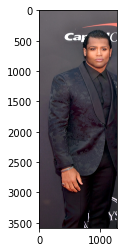

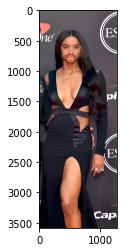

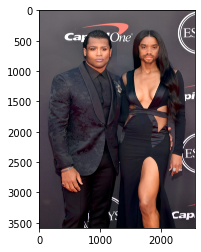

In [32]:
swapped = swap_faces(onbekend,blendmode='pyramid',plot_Delaunay_Keypoints=False,detail='all')
plt.figure()
plt.imshow(swapped)

Image does not have enough recognisable faces


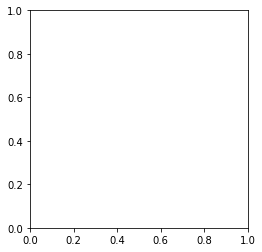

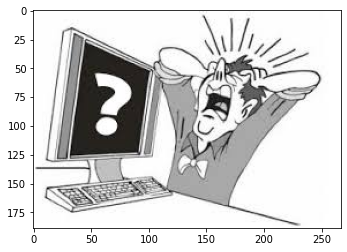

In [33]:
swapped = swap_faces(solo,blendmode='pyramid',plot_Delaunay_Keypoints=True,detail='all')
plt.figure()
plt.imshow(swapped)

pts[array([[209, 194],
       [212, 222],
       [216, 250],
       [222, 277],
       [236, 301],
       [256, 322],
       [280, 339],
       [306, 352],
       [331, 355],
       [355, 347],
       [374, 331],
       [392, 311],
       [405, 287],
       [413, 261],
       [415, 234],
       [416, 207],
       [416, 180],
       [232, 178],
       [245, 166],
       [264, 160],
       [284, 160],
       [304, 166],
       [333, 162],
       [351, 155],
       [368, 151],
       [386, 153],
       [398, 164],
       [320, 184],
       [322, 202],
       [324, 219],
       [325, 237],
       [304, 250],
       [315, 252],
       [326, 254],
       [336, 250],
       [345, 246],
       [257, 190],
       [267, 181],
       [281, 180],
       [293, 190],
       [281, 194],
       [268, 194],
       [345, 185],
       [354, 173],
       [367, 172],
       [377, 179],
       [369, 185],
       [356, 186],
       [279, 277],
       [297, 275],
       [314, 274],
       [325, 275],
       [

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\2344588173.py:21: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  var = pyramid_reduce(var,downscale = downscale,multichannel=True)
C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3472033233.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(pyramid[i+1],upscale=upscale,multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


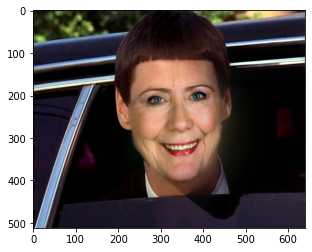

In [34]:
swapped = swap_faces(carrey,clinton,blendmode='pyramid',plot_Delaunay_Keypoints=False,detail='all',flip_faces=(False,False))
plt.figure()
plt.imshow(swapped)

pts[array([[129, 359],
       [130, 401],
       [134, 442],
       [137, 485],
       [151, 525],
       [178, 558],
       [214, 587],
       [253, 613],
       [298, 621],
       [343, 613],
       [386, 587],
       [424, 556],
       [453, 519],
       [467, 477],
       [471, 431],
       [474, 385],
       [473, 339],
       [149, 338],
       [168, 316],
       [197, 308],
       [228, 308],
       [258, 317],
       [316, 312],
       [347, 300],
       [380, 296],
       [413, 302],
       [436, 323],
       [288, 353],
       [289, 382],
       [290, 411],
       [291, 441],
       [257, 459],
       [274, 463],
       [293, 469],
       [312, 461],
       [330, 455],
       [187, 360],
       [207, 347],
       [230, 346],
       [248, 364],
       [228, 367],
       [205, 366],
       [339, 358],
       [358, 340],
       [381, 337],
       [399, 349],
       [383, 357],
       [361, 359],
       [213, 494],
       [242, 490],
       [272, 487],
       [295, 490],
       [

C:\Users\roela\AppData\Local\Temp\ipykernel_18228\2344588173.py:21: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_reduce`. It will be removed in version 1.0. Please use `channel_axis` instead.
  var = pyramid_reduce(var,downscale = downscale,multichannel=True)
C:\Users\roela\AppData\Local\Temp\ipykernel_18228\3472033233.py:18: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_expand`. It will be removed in version 1.0. Please use `channel_axis` instead.
  prev = pyramid_expand(pyramid[i+1],upscale=upscale,multichannel=True)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


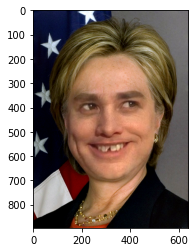

In [35]:
swapped = swap_faces(clinton,carrey,blendmode='pyramid',plot_Delaunay_Keypoints=False,detail='all',flip_faces=(False,True))
plt.figure()
plt.imshow(swapped)